In [1]:
import os

In [2]:
os.chdir("../")

In [3]:
%pwd

'/Users/macbookpro/Documents/Documents - Macbook’s MacBook Pro/career/career_chief_rep'

In [ ]:
# # Configuration for spaCy Named Entity Recognition (NER) model training
# spacy_ner:
#   root_dir: artifacts/model_training/spacy_ner  # Root directory for training artifacts
#   ner_job_description_extractor_dir: "artifacts/model_training/NERJobDescriptionExtractor/Model"
#   json_annotated_path: artifacts/model_training/spacy_ner/project-4-at-2024-04-01-07-30-2333a63c.json  # Path to annotated data
#   output_path: artifacts/model_training/spacy_ner/output/converted_data.spacy  # Output path for the converted spaCy data
#   train_data_path: artifacts/data_transformation/train_data.csv  # Path to unannotated training data
#   test_data_path: artifacts/data_transformation/test_data.csv  # Path to unannotated test data
#   val_data_path: artifacts/data_transformation/val_data.csv  # Path to unannotated validation data
#   spacy_train: artifacts/model_training/spacy_ner/output/train_data.spacy  # Processed spaCy training data
#   spacy_dev: artifacts/model_training/spacy_ner/output/dev_data.spacy  # Processed spaCy dev (validation) data
#   gpu_allocator: pytorch  # GPU allocator (use 'pytorch' for PyTorch)
#   components:  # NLP pipeline components
#     - name: "ner"
#       factory: "ner"
#   training:  # Training parameters
#     batch_size: 128
#     dropout: 0.5
#     optimizer:
#       learn_rate: 0.001
#     patience: 3
#     max_epochs: 20


In [4]:
from dataclasses import dataclass
from pathlib import Path
from typing import List, Dict, Any

@dataclass
class SpacyNERConfig:
    """
    Represents the configuration for spaCy Named Entity Recognition (NER) model training.

    This class is intended to be populated with values from a YAML configuration file,
    providing structured access to the configurations within the Python codebase.
    
    Attributes:
        root_dir (Path): Directory for storing training artifacts and results.
        json_annotated_path (Path): Path to the JSON file with annotations from Label Studio.
        output_path (Path): Destination path for the converted spaCy data format.
        train_data_path (Path): Path to the CSV file containing unannotated training data.
        test_data_path (Path): Path to the CSV file containing unannotated test data.
        val_data_path (Path): Path to the CSV file containing unannotated validation data.
        spacy_train (Path): Path for the processed spaCy training data.
        spacy_dev (Path): Path for the processed spaCy development (validation) data.
        gpu_allocator (str): The GPU allocator for training, e.g., 'pytorch'.
        components (List[Dict[str, Any]]): Configuration for the NER pipeline components.
        training (Dict[str, Any]): Dictionary containing the training parameters.
    """
    root_dir: Path
    ner_job_description_extractor_dir: Path
    json_annotated_path: Path
    output_path: Path
    train_data_path: Path
    test_data_path: Path
    val_data_path: Path
    spacy_train: Path
    spacy_dev: Path
    gpu_allocator: str
    components: List[Dict[str, Any]]
    training: Dict[str, Any]


In [5]:
from src.career_chief.constants import *
from src.career_chief.utils.common import read_yaml, create_directories
from src.career_chief import logger
from src.career_chief.entity.config_entity import (DataIngestionConfig, DataValidationConfig, SpacyNERConfig)

class ConfigurationManager:
    """
    ConfigurationManager manages configurations needed for the data pipeline.

    The class reads configuration, parameter, and schema settings from specified files
    and provides a set of methods to access these settings. It also takes care of
    creating necessary directories defined in the configurations.

    Attributes:
    - config (dict): Configuration settings.
    - params (dict): Parameters for the pipeline.
    - schema (dict): Schema information.
    """
    
    def __init__(self, 
                 config_filepath = CONFIG_FILE_PATH, 
                 params_filepath = PARAMS_FILE_PATH, 
                 schema_filepath = SCHEMA_FILE_PATH) -> None:
        """
        Initialize ConfigurationManager with configurations, parameters, and schema.

        Args:
        - config_filepath (Path): Path to the configuration file.
        - params_filepath (Path): Path to the parameters file.
        - schema_filepath (Path): Path to the schema file.

        Creates:
        - Directories specified in the configuration.
        """
        self.config = self._read_config_file(config_filepath, "config")
        self.params = self._read_config_file(params_filepath, "params")
        self.schema = self._read_config_file(schema_filepath, "schema")

        # Create the directory for storing artifacts if it doesn't exist
        create_directories([self.config.artifacts_root])

    def _read_config_file(self, filepath: str, config_name: str) -> dict:
        """
        Read a configuration file and return its content.

        Args:
        - filepath (str): Path to the configuration file.
        - config_name (str): Name of the configuration (for logging purposes).

        Returns:
        - dict: Configuration settings.

        Raises:
        - Exception: If there's an error reading the file.
        """
        try:
            return read_yaml(filepath)
        except Exception as e:
            logger.error(f"Error reading {config_name} file: {filepath}. Error: {e}")
            raise

    
    def get_spacy_ner_config(self) -> SpacyNERConfig:
        """
        Fetches and constructs the spaCy NER training configuration.

        Extracts settings related to spaCy NER model training from the loaded YAML
        configurations and returns them encapsulated in a SpacyNERConfig object.

        Returns:
        - SpacyNERConfig: Configuration object for spaCy NER model training.

        Raises:
        - KeyError: If any required configuration is missing.
        """
        try:
            ner_config = self.config['spacy_ner']
            
            # Dynamically construct and return the SpacyNERConfig object
            return SpacyNERConfig(
                root_dir=Path(ner_config['root_dir']),
                ner_job_description_extractor_dir=Path(ner_config['ner_job_description_extractor_dir']),
                json_annotated_path=Path(ner_config['json_annotated_path']),
                output_path=Path(ner_config['output_path']),
                train_data_path=Path(ner_config['train_data_path']),
                test_data_path=Path(ner_config['test_data_path']),
                val_data_path=Path(ner_config['val_data_path']),
                spacy_train=Path(ner_config['spacy_train']),
                spacy_dev=Path(ner_config['spacy_dev']),
                gpu_allocator=ner_config['gpu_allocator'],
                components=ner_config['components'],
                training=ner_config['training']
            )

        except KeyError as e:
            logger.error(f"A required configuration is missing in the 'spacy_ner' section: {e}")
            raise KeyError(f"Missing configuration in 'spacy_ner': {e}") from e

# Component


In [6]:
import subprocess
import re
import random
import json
from pathlib import Path
from sklearn.model_selection import train_test_split


import random
import itertools

import spacy
from spacy.tokens import DocBin
from spacy.scorer import Scorer
from spacy.util import minibatch, compounding, load_config
from spacy.training.loop import train
from spacy.training import Example

import matplotlib.pyplot as plt
import pandas as pd

from tqdm import tqdm


from src.career_chief import logger

class SpacyCustomNERModel:
    def __init__(self, config):
        self.config = config
        self.nlp = spacy.blank("en")  # Create a blank English model
        if "ner" not in self.nlp.pipe_names:
            self.ner = self.nlp.add_pipe("ner")

    def process_annotations(self, data, nlp, progress_bar=None):
        """
        Processes annotations from a structured JSON format into spaCy's binary DocBin format.
        
        This function takes a list of annotated items, where each item includes the text and its annotations,
        and processes these into a spaCy-compatible format for NER training. Each annotation is used to create
        a `Span` object in spaCy, marking entity boundaries and their labels within the document text.
        
        Args:
            data (list): A list of annotated data items. Each item is expected to have keys 'data' and 'annotations',
                        where 'data' contains the text and 'annotations' is a list of annotation objects.
            nlp (Language): An instance of a spaCy Language object for document processing.
            progress_bar (tqdm.tqdm, optional): A tqdm progress bar instance to track the progress. Defaults to None.
        
        Returns:
            DocBin: A DocBin object containing the processed documents with entities marked.
        """
        doc_bin = DocBin()  # Initialize DocBin to store processed documents.

        # Iterate over each annotated item in the input data.
        for item in data:
            # Extract text for the current item.
            text = item["data"]["text"]
            # Tokenize the text using the provided spaCy Language object.
            doc = nlp.make_doc(text)

            # Prepare a list to store entity spans.
            ents = []
            # Set to track existing spans and avoid overlaps.
            existing_spans = set()

            # Iterate over each annotation in the current item.
            for annot in item["annotations"][0]["result"]:
                # Extract start and end indices, and the entity label.
                start = annot["value"]["start"]
                end = annot["value"]["end"]
                label = annot["value"]["labels"][0]

                # Ensure the new span does not overlap with existing ones.
                if not any((start <= s < end) or (start < e <= end) for s, e in existing_spans):
                    # Create a span from the annotation.
                    span = doc.char_span(start, end, label=label, alignment_mode="strict")
                    # If the span is valid (i.e., not None), add it to the list of entities.
                    if span is not None:
                        ents.append(span)
                        # Record the span boundaries to check for future overlaps.
                        existing_spans.add((start, end))

            # Update the document with identified entities.
            doc.ents = ents
            # Add the document to DocBin.
            doc_bin.add(doc)
            
            # Update the progress bar if provided
            if progress_bar is not None:
                progress_bar.update(1)
        
        # Log completion of annotation processing.
        logger.info("Annotations processed successfully.")
        return doc_bin


    def split_and_save_data(self, docs, test_size=0.2, progress_bar=None):
        """
        Splits the list of spaCy Doc objects into training and development sets,
        then saves them as .spacy files.

        Args:
            docs (list): The full list of spaCy Doc objects.
            test_size (float): The proportion of the dataset to include in the test split.
            progress_bar (tqdm.tqdm, optional): A tqdm progress bar instance to track the progress. Defaults to None.
        """
        # Split the docs into training and development sets
        train_docs, dev_docs = train_test_split(docs, test_size=test_size, random_state=42)
        logger.info(f"Split data into {len(train_docs)} training and {len(dev_docs)} development examples.")

        # Save the train and dev DocBins
        train_bin = DocBin(docs=train_docs, store_user_data=True)
        dev_bin = DocBin(docs=dev_docs, store_user_data=True)
        train_bin.to_disk(self.config.spacy_train)
        dev_bin.to_disk(self.config.spacy_dev)
        logger.info("Training and development data saved successfully.")

        # Update the progress bar if provided
        if progress_bar is not None:
            progress_bar.update(1)


    def read_spacy_annotations(self, file_path):
        """
        Reads and prints spaCy annotations from a .spacy file for verification.

        Args:
            file_path (str): Path to the .spacy file containing annotated data.
        """
        nlp = spacy.blank("en")  # Load the blank English model
        doc_bin = DocBin().from_disk(file_path)  # Load the DocBin file
        docs = list(doc_bin.get_docs(nlp.vocab))  # Create a list of Doc objects

        for doc in docs:
            print(f"Text: {doc.text[:50]}...")  # Print document text
            for ent in doc.ents:
                print(f" - Entity: {ent.text}, Label: {ent.label_}")  # Print each entity and its label
            print("\n---\n")

        logger.info(f"Annotations from {file_path} read and printed for verification.")
        return docs

    
    def get_labels(self, docs):
        """
        Extracts unique entity labels from the provided spaCy documents.

        Args:
            docs (list of spacy.Doc): List of spaCy Doc objects containing annotations.

        Returns:
            set: A set containing unique entity labels.
        """
        labels = set()
        for doc in docs:
            for ent in doc.ents:
                labels.add(ent.label_)
        return labels
    
    def train_ner_model(self):
        if self.config.gpu_allocator:
            spacy.require_gpu()
        nlp = spacy.blank("en")  # Load a blank spaCy model

        # Create or get the 'ner' component
        if 'ner' not in nlp.pipe_names:
            ner = nlp.add_pipe('ner')
        else:
            ner = nlp.get_pipe('ner')

        # Load training and development data
        train_docs = list(DocBin().from_disk(self.config.spacy_train).get_docs(nlp.vocab))
        dev_docs = list(DocBin().from_disk(self.config.spacy_dev).get_docs(nlp.vocab))

        # Add labels to the 'ner' component
        for label in self.get_labels(train_docs + dev_docs):
            ner.add_label(label)

        # Disable other pipeline components during training
        other_pipes = [pipe for pipe in nlp.pipe_names if pipe != 'ner']
        with nlp.disable_pipes(*other_pipes):
            optimizer = nlp.begin_training()

            for epoch in range(self.config.training["max_epochs"]):
                random.shuffle(train_docs)
                losses = {}

                # Training loop
                for batch in minibatch(train_docs, size=compounding(4., 32., 1.001)):
                    examples = [Example.from_dict(nlp.make_doc(doc.text), {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}) for doc in batch]
                    nlp.update(examples, drop=0.3, losses=losses)
                print(f"Losses at epoch {epoch}: {losses}")

                # Evaluation on the development set
                dev_examples = [Example.from_dict(nlp.make_doc(doc.text), {"entities": [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]}) for doc in dev_docs]
                scores = nlp.evaluate(dev_examples)
                print(f"Epoch {epoch} - Precision: {scores['ents_p']:.3f}, Recall: {scores['ents_r']:.3f}, F1 Score: {scores['ents_f']:.3f}")


    def finetune_pretrained_ner_model(self, progress_bar=None):
        """
        Fine-tunes a pretrained NER model using spaCy's train command.

        Args:
            progress_bar (tqdm.tqdm, optional): A tqdm progress bar instance to track the progress. Defaults to None.

        Returns:
            pd.DataFrame: DataFrame containing the training metrics.
        """
        if self.config.gpu_allocator:
            spacy.require_gpu()
            
        # Directory paths
        model_dir = Path(self.config.ner_job_description_extractor_dir)
        output_dir = model_dir / "finetuned_model"
        config_path = model_dir / "config.cfg"
        
        # Ensure output directory exists
        output_dir.mkdir(parents=True, exist_ok=True)

        # Prepare the spacy train command
        train_command = [
            "spacy", "train",
            str(config_path),
            "--output", str(output_dir),
            "--paths.train", str(self.config.spacy_train),
            "--paths.dev", str(self.config.spacy_dev),
            "--gpu-id", "0" if self.config.gpu_allocator else "-1"
        ]
        
        # Execute the training command and capture the output
        result = subprocess.run(train_command, capture_output=True, text=True)
        
        # Check for errors
        if result.returncode != 0:
            print("Training failed with the following error:")
            print(result.stderr)
            return

        print(result.stdout)
        
        # Parse the stdout to extract the metrics
        metrics_pattern = re.compile(r"\s+(\d+)\s+(\d+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)\s+([\d.]+)")
        epochs, losses_tok2vec, losses_ner, ents_f, ents_p, ents_r, score = [], [], [], [], [], [], []
        
        for line in result.stdout.split("\n"):
            match = metrics_pattern.search(line)
            if match:
                epoch, batch, loss_tok2vec, loss_ner, f, p, r, s = match.groups()
                epochs.append(int(epoch))
                losses_tok2vec.append(float(loss_tok2vec))
                losses_ner.append(float(loss_ner))
                ents_f.append(float(f))
                ents_p.append(float(p))
                ents_r.append(float(r))
                score.append(float(s))
        
        # Optionally, save the metrics to a DataFrame for further analysis or visualization
        metrics_df = pd.DataFrame({
            "Epoch": epochs,
            "Loss Tok2Vec": losses_tok2vec,
            "Loss NER": losses_ner,
            "ENTS_F": ents_f,
            "ENTS_P": ents_p,
            "ENTS_R": ents_r,
            "Score": score
        })
        
        # Save or return the DataFrame for visualization
        metrics_df.to_csv(output_dir / "training_metrics.csv", index=False)
        print("Training metrics saved to:", output_dir / "training_metrics.csv")
        
        # Update the progress bar if provided
        if progress_bar is not None:
            progress_bar.update(1)
        
        return metrics_df



    def run(self):
        try:
            # Load annotations from the JSON file
            with open(self.config.json_annotated_path, 'r', encoding='utf-8') as f:
                annotated_data = json.load(f)
            
            # Initialize a blank English spaCy model
            nlp = spacy.blank("en")
            logger.info("Blank spaCy model initialized.")

            # Process annotations using the loaded data and the initialized nlp object
            doc_bin = self.process_annotations(annotated_data, nlp)
            
            # Optionally, display a progress bar for the next steps
            total_steps = 3  # Number of steps in the pipeline
            with tqdm(total=total_steps, desc="Processing Annotations") as pbar:
                # Increment the progress bar
                pbar.update(1)

                # split_and_save_data expects a list of docs, not a DocBin
                # Convert DocBin to list of docs for splitting and saving
                docs = list(doc_bin.get_docs(nlp.vocab))

                # Split the processed annotations into training and development data and save them
                self.split_and_save_data(docs, progress_bar=pbar)
                
                # Increment the progress bar
                pbar.update(1)

                # Optional: Read back the saved annotations for verification
                logger.info("Reading back saved annotations for verification.")
                self.read_spacy_annotations(self.config.output_path)
                
                # Increment the progress bar
                pbar.update(1)
            
            # Train the custom NER model from Empty Spacy Doc
            # self.train_ner_model()
            
            # Fine-tuning from pretrained model with progress bar
            with tqdm(total=1, desc="Fine-tuning Pretrained NER Model") as pbar:
                self.finetune_pretrained_ner_model(progress_bar=pbar)
            
            print("Finished finetuning from the pretrained model.")

        except Exception as e:
            logger.error(f"Error occurred during model training - {str(e)}")
            raise e





# Pipeline

In [ ]:
from src.career_chief import logger
from src.career_chief.config.configuration import ConfigurationManager
# from src.career_chief.components.spacy_ner_custom_model import SpacyCustomNERModel

class SpacyCustomNERModelPipeline:
    """
    Orchestrates the pipeline for training a custom spaCy Named Entity Recognition (NER) model.

    This class manages the end-to-end process of configuring, training, and evaluating
    a custom spaCy NER model. It leverages the ConfigurationManager to fetch necessary
    configurations and uses the SpacyCustomNERModel component to execute the training process.
    """

    STAGE_NAME = "Custom NER spaCy Model Training Pipeline"

    def __init__(self):
        """
        Initializes the pipeline with the ConfigurationManager instance
        to access the necessary configurations for the NER model training.
        """
        self.config_manager = ConfigurationManager()
        logger.info(f"{self.STAGE_NAME} initialized successfully.")

    def run_spacy_custom_ner_model(self):
        """
        Executes the spaCy custom NER model training pipeline.

        This method orchestrates the process of loading configurations, processing annotations,
        training the model, and optionally evaluating its performance. It handles and logs
        any errors that occur during the pipeline execution.
        """
        try:
            logger.info(f"{self.STAGE_NAME}: Fetching model configuration.")
            spacy_custom_ner_model_config = self.config_manager.get_spacy_ner_config()

            logger.info(f"{self.STAGE_NAME}: Initializing the SpacyCustomNERModel component.")
            spacy_model_training = SpacyCustomNERModel(config=spacy_custom_ner_model_config)

            logger.info(f"{self.STAGE_NAME}: Executing the training pipeline.")
            spacy_model_training.run()

            logger.info(f"{self.STAGE_NAME}: Training pipeline executed successfully.")

        except Exception as e:
            logger.error(f"{self.STAGE_NAME}: Error occurred during model training - {str(e)}")
            raise e

if __name__ == '__main__':
    pipeline = SpacyCustomNERModelPipeline()
    pipeline.run_spacy_custom_ner_model()


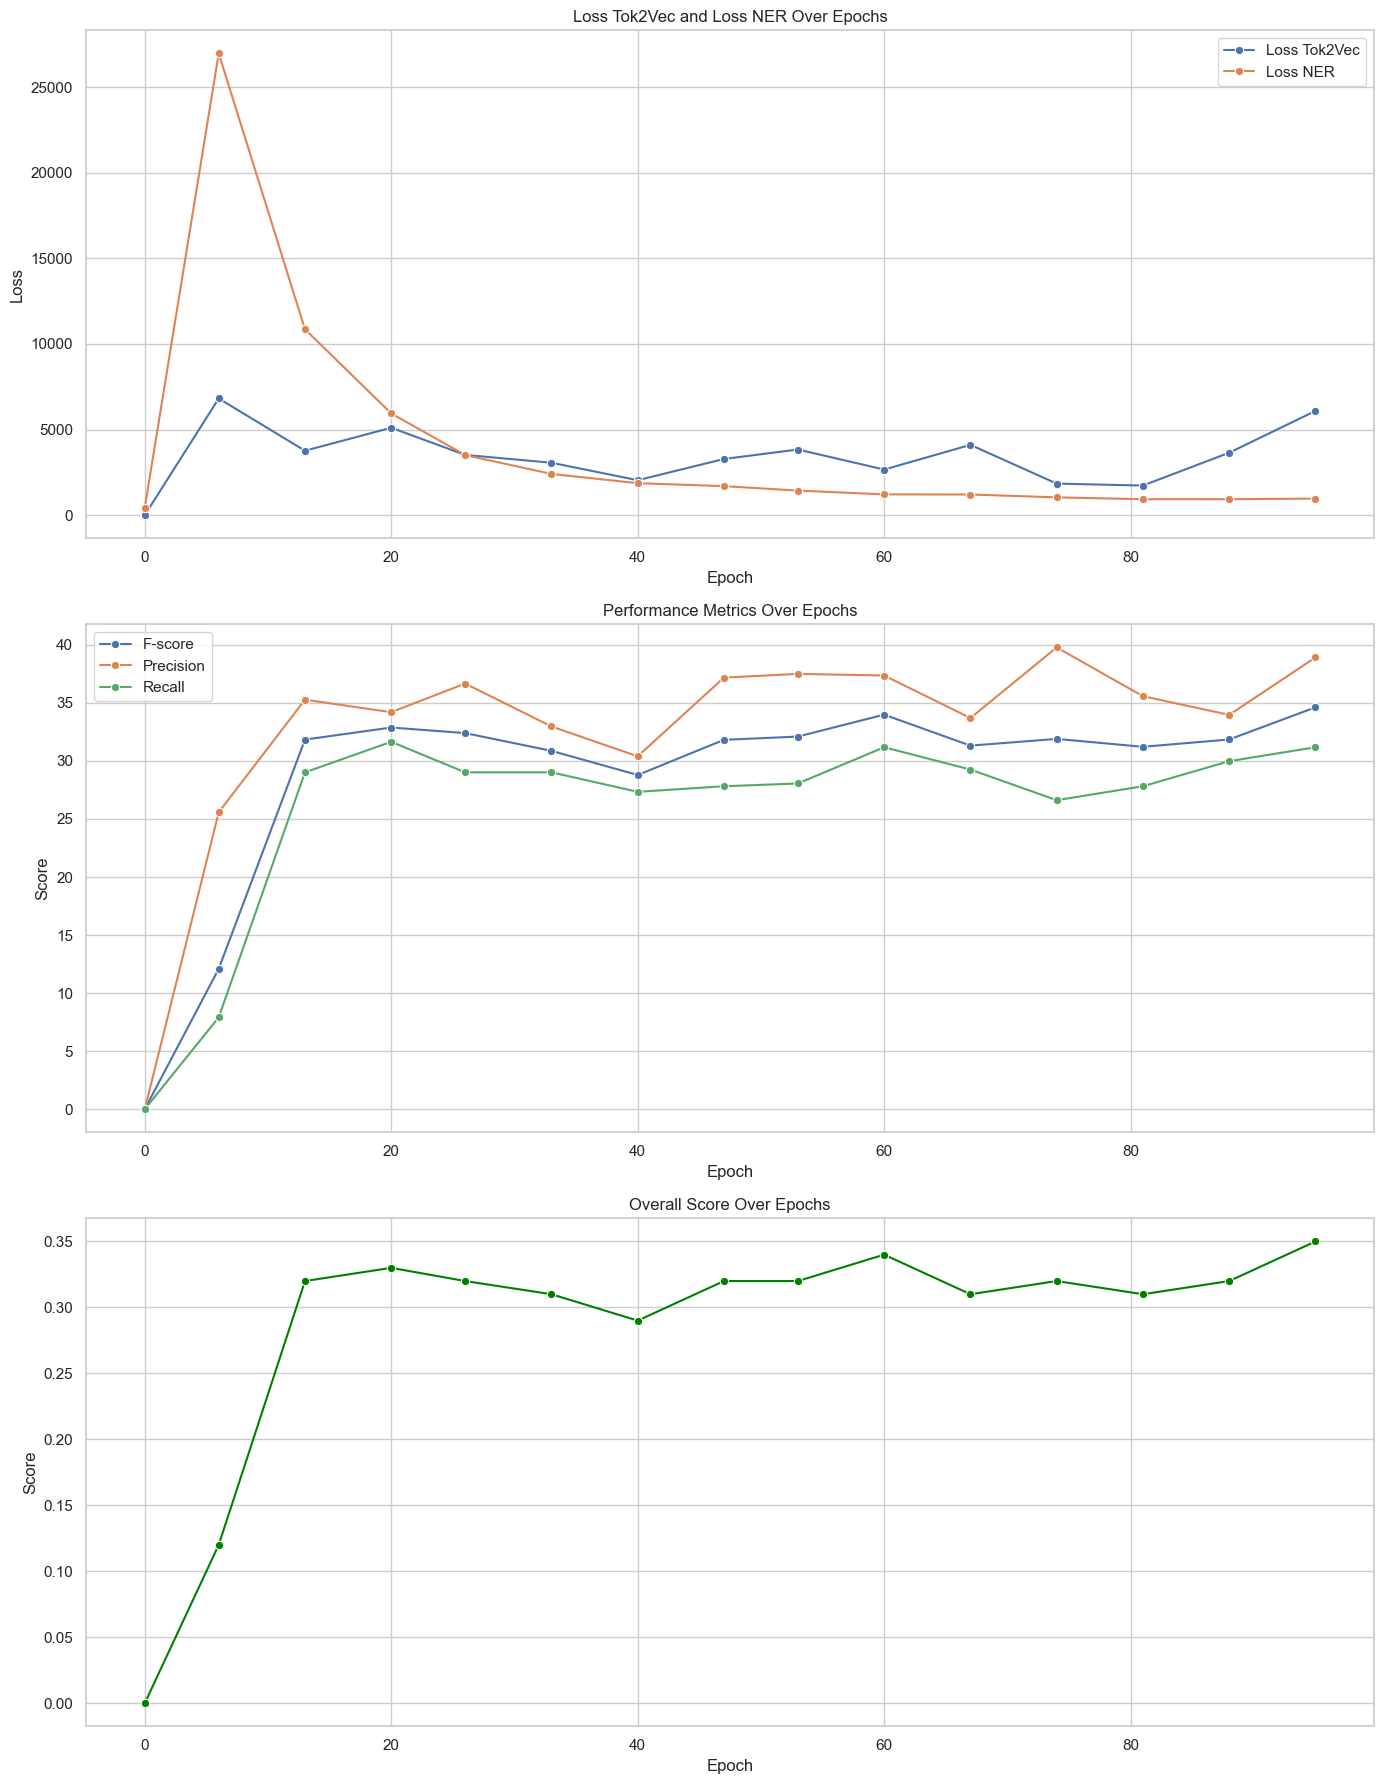

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Function to visualize training metrics
def visualize_training_metrics(metrics_csv_path):
    """
    Visualizes the training metrics including loss, F1 score, precision, recall, and score from a CSV file.

    Parameters:
    - metrics_csv_path: str, path to the CSV file containing the training metrics.
    """
    # Load the metrics from the CSV file
    metrics_df = pd.read_csv(metrics_csv_path)

    # Setting the style
    sns.set(style="whitegrid")

    # Creating subplots for each type of analysis
    fig, ax = plt.subplots(3, 1, figsize=(14, 18))

    # Plotting Loss Tok2Vec and Loss NER
    sns.lineplot(x='Epoch', y='Loss Tok2Vec', data=metrics_df, marker='o', label='Loss Tok2Vec', ax=ax[0])
    sns.lineplot(x='Epoch', y='Loss NER', data=metrics_df, marker='o', label='Loss NER', ax=ax[0])
    ax[0].set_title('Loss Tok2Vec and Loss NER Over Epochs')
    ax[0].set_ylabel('Loss')
    ax[0].legend()

    # Plotting ENTS_F, ENTS_P, and ENTS_R
    sns.lineplot(x='Epoch', y='ENTS_F', data=metrics_df, marker='o', label='F-score', ax=ax[1])
    sns.lineplot(x='Epoch', y='ENTS_P', data=metrics_df, marker='o', label='Precision', ax=ax[1])
    sns.lineplot(x='Epoch', y='ENTS_R', data=metrics_df, marker='o', label='Recall', ax=ax[1])
    ax[1].set_title('Performance Metrics Over Epochs')
    ax[1].set_ylabel('Score')
    ax[1].legend()

    # Plotting the Overall Score
    sns.lineplot(x='Epoch', y='Score', data=metrics_df, marker='o', color='green', ax=ax[2])
    ax[2].set_title('Overall Score Over Epochs')
    ax[2].set_ylabel('Score')

    plt.tight_layout()
    plt.show()


# Example usage
visualize_training_metrics("artifacts/model_training/NERJobDescriptionExtractor/Model/finetuned_model/training_metrics.csv")


# Test our model on train jobs data

In [29]:
import spacy
import pandas as pd
from pathlib import Path
from tqdm import tqdm
from src.career_chief import logger  # Importing the logger

class EntityExtractorFromJobDescriptions:
    """
    A class for extracting entities from job descriptions using a fine-tuned NER model.

    Attributes:
        model_path (str): Path to the fine-tuned NER model.
        data_path (str): Path to the input CSV file containing job descriptions.
        output_path (str): Path where the extracted entities CSV file will be saved.
    """
    
    def __init__(self, model_path, data_path, output_path):
        """
        Initializes the EntityExtractorFromJobDescriptions with specified model, data, and output paths.
        
        Parameters:
            model_path (str): Path to the fine-tuned NER model.
            data_path (str): Path to the input CSV file.
            output_path (str): Path for the output CSV file with extracted entities.
        """
        self.model_path = model_path
        self.data_path = data_path
        self.output_path = output_path

    def load_model(self):
        """Loads the fine-tuned NER model from the specified path."""
        logger.info("Loading the fine-tuned NER model.")
        return spacy.load(self.model_path)

    def load_data(self):
        """Loads the job descriptions dataset from a CSV file."""
        logger.info(f"Loading data from {self.data_path}.")
        return pd.read_csv(self.data_path)

    def extract_and_save_entities(self):
        """
        Extracts entities from the job descriptions using the NER model and saves the results to a CSV file.
        Progress is tracked and logged.
        """
        nlp = self.load_model()
        data = self.load_data()

        # Convert all entries in the 'cleaned_text' column to strings to prevent type-related errors.
        data['cleaned_text'] = data['cleaned_text'].astype(str)

        results = []

        logger.info("Starting entity extraction from job descriptions.")
        
        # Process each job description in the dataset.
        for index, row in tqdm(data.iterrows(), total=data.shape[0], desc="Extracting entities"):
            doc = nlp(row['cleaned_text'])
            entities = [(ent.text, ent.label_) for ent in doc.ents]
            job_id = row['job_id']
            for entity_text, entity_label in entities:
                results.append({
                    "job_id": job_id,
                    "entity_text": entity_text,
                    "entity_label": entity_label
                })

        results_df = pd.DataFrame(results)
        
        # Ensuring the directory for the output file exists.
        Path(self.output_path).parent.mkdir(parents=True, exist_ok=True)
        
        # Saving the extracted entities to a CSV file.
        results_df.to_csv(self.output_path, index=False)
        logger.info(f"Extracted entities saved successfully to {self.output_path}.")


In [26]:
model_path = "artifacts/model_training/NERJobDescriptionExtractor/Model/finetuned_model/model-best"
data_path = "artifacts/data_transformation/train_data.csv"
output_path = "artifacts/model_training/NERJobDescriptionExtractor/Model/finetuned_model/train_data_extracted_entities.csv"
extract_ner = EntityExtractorFromJobDescriptions(model_path, data_path, output_path)
extract_ner.extract_and_save_entities()

Extracting entities: 100%|██████████| 26572/26572 [11:06<00:00, 39.90it/s]


Extracted entities saved to artifacts/model_training/NERJobDescriptionExtractor/Model/finetuned_model/train_data_extracted_entities.csv


In [27]:
train_data_extracted_entities = pd.read_csv("artifacts/model_training/NERJobDescriptionExtractor/Model/finetuned_model/train_data_extracted_entities.csv")

In [30]:
train_data_extracted_entities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 378171 entries, 0 to 378170
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   job_id        378171 non-null  object
 1   entity_text   378171 non-null  object
 2   entity_label  378171 non-null  object
dtypes: object(3)
memory usage: 8.7+ MB


In [31]:
train_data_extracted_entities.head(10)

,job_id,entity_text,entity_label
0,eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...,Sr Data Analyst,Job Title
1,eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...,Data Analyst,Job Title
2,eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...,critical thinking,Soft Skills
3,eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...,thought partner to the stakeholder community a...,Duties and Responsibilities
4,eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...,Looker Excel etc,Job Title
5,eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...,product management user design groups data eng...,Skills
6,eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...,communication,Soft Skills
7,eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...,interpersonal,Soft Skills
8,eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...,Partner with key stakeholders,Duties and Responsibilities
9,eyJqb2JfdGl0bGUiOiJTZW5pb3IgRGF0YSBBbmFseXN0Ii...,analyses that drive and inform strategic decis...,Duties and Responsibilities


# Merge Dataset

Merging our datasets before proceeding with semantic processing, role labeling, and subsequent steps

In [41]:
# import pandas as pd
# from src.career_chief import logger
# from tqdm.auto import tqdm

# class DatasetMerger:
#     """
#     A class to merge original job descriptions with their corresponding extracted entities
#     from both initial and fine-tuned NER models, showcasing progress with tqdm where applicable.
#     """
    
#     def __init__(self, original_dataset_path, extracted_entities_path, output_path):
#         """
#         Initializes the DatasetMerger with paths to the datasets and output.
#         """
#         self.original_dataset_path = original_dataset_path
#         self.extracted_entities_path = extracted_entities_path
#         self.output_path = output_path

#     def load_and_merge_datasets(self):
#         """
#         Loads the original and extracted entities datasets and merges them on 'job_id'.
#         Showcases loading progress with tqdm for the extracted entities dataset.
#         """
#         logger.info("Loading datasets.")
#         # Load the original dataset normally as its size is manageable
#         original_df = pd.read_csv(self.original_dataset_path)
        
#         # Load the extracted entities dataset with progress indication
#         logger.info("Loading extracted entities dataset with progress tracking.")
#         chunk_size = 5000  # Adjust based on your dataset size and memory constraints
#         extracted_entities_iter = pd.read_csv(self.extracted_entities_path, chunksize=chunk_size)
#         extracted_entities_df = pd.concat([chunk for chunk in tqdm(extracted_entities_iter, desc="Loading Extracted Entities")])
        
#         logger.info("Merging datasets on 'job_id'.")
#         merged_df = pd.merge(original_df, extracted_entities_df, on='job_id', how='left')
        
#         return merged_df

#     def save_merged_dataset(self):
#         """
#         Saves the merged dataset to the specified output path.
#         """
#         merged_df = self.load_and_merge_datasets()
#         logger.info(f"Saving merged dataset to {self.output_path}.")
#         merged_df.to_csv(self.output_path, index=False)
#         logger.info("Merged dataset saved successfully.")

import pandas as pd
from src.career_chief import logger
from tqdm.auto import tqdm

class DatasetMerger:
    """
    Merges original job descriptions with extracted entities from NER models, with progress tracking.
    
    Attributes:
        original_dataset_path (str): Path to the original dataset CSV file.
        extracted_entities_path (str): Path to the extracted entities CSV file.
        output_path (str): Path for the merged dataset CSV output.
    """
    
    def __init__(self, original_dataset_path, extracted_entities_path, output_path):
        """
        Initializes DatasetMerger with file paths for datasets and output.
        """
        self.original_dataset_path = original_dataset_path
        self.extracted_entities_path = extracted_entities_path
        self.output_path = output_path

    def load_datasets_with_progress(self):
        """
        Loads the original and extracted entities datasets with progress tracking.
        
        Returns:
            tuple: A tuple containing two pandas DataFrames (original_df, extracted_entities_df).
        """
        logger.info("Loading original dataset with progress tracking.")
        # Assuming the original dataset might also be large and benefit from chunk loading
        original_iter = pd.read_csv(self.original_dataset_path, chunksize=5000)
        original_df = pd.concat(tqdm(original_iter, desc="Original Dataset"))

        logger.info("Loading extracted entities dataset with progress tracking.")
        extracted_entities_iter = pd.read_csv(self.extracted_entities_path, chunksize=5000)
        extracted_entities_df = pd.concat(tqdm(extracted_entities_iter, desc="Extracted Entities Dataset"))

        return original_df, extracted_entities_df

    def merge_datasets_with_progress(self, original_df, extracted_entities_df):
        """
        Merges the original and extracted entities datasets based on 'job_id'.
        
        Parameters:
            original_df (pd.DataFrame): The original dataset DataFrame.
            extracted_entities_df (pd.DataFrame): The extracted entities DataFrame.
            
        Returns:
            pd.DataFrame: The merged DataFrame.
        """
        logger.info("Merging datasets on 'job_id'.")
        # Directly merging as there's no iterative process to track with tqdm
        merged_df = pd.merge(original_df, extracted_entities_df, on='job_id', how='left')
        logger.info("Datasets merged successfully.")
        
        return merged_df

    def save_merged_dataset(self, merged_df):
        """
        Saves the merged dataset to a CSV file, with path specified during class initialization.
        
        Parameters:
            merged_df (pd.DataFrame): The merged dataset DataFrame to be saved.
        """
        logger.info(f"Saving merged dataset to {self.output_path}.")
        # Saving isn't directly trackable with tqdm but logging indicates progress
        merged_df.to_csv(self.output_path, index=False)
        logger.info("Merged dataset saved successfully.")



In [42]:
def main():
    """
    Main function to execute dataset merging process.
    """
    # Define paths
    original_dataset_path = 'artifacts/data_transformation/train_data.csv'
    extracted_entities_path = 'artifacts/model_training/NERJobDescriptionExtractor/Model/finetuned_model/train_data_extracted_entities.csv'
    output_path = 'artifacts/data_transformation/merged_train_data.csv'

    # Initialize and use DatasetMerger
    merger = DatasetMerger(original_dataset_path, extracted_entities_path, output_path)
    original_df, extracted_entities_df = merger.load_datasets_with_progress()
    merged_df = merger.merge_datasets_with_progress(original_df, extracted_entities_df)
    merger.save_merged_dataset(merged_df)

    logger.info("Dataset merging process completed successfully.")

if __name__ == "__main__":
    main()

[2024-04-10 00:14:13,909: 77: career_chief_logger: INFO: 3986530301:  Loading original dataset with progress tracking.]


Original Dataset: 0it [00:00, ?it/s]

[2024-04-10 00:14:16,896: 82: career_chief_logger: INFO: 3986530301:  Loading extracted entities dataset with progress tracking.]


Extracted Entities Dataset: 0it [00:00, ?it/s]

[2024-04-10 00:14:19,137: 99: career_chief_logger: INFO: 3986530301:  Merging datasets on 'job_id'.]
[2024-04-10 00:14:19,719: 102: career_chief_logger: INFO: 3986530301:  Datasets merged successfully.]
[2024-04-10 00:14:19,721: 113: career_chief_logger: INFO: 3986530301:  Saving merged dataset to artifacts/data_transformation/merged_train_data.csv.]
[2024-04-10 00:15:49,338: 116: career_chief_logger: INFO: 3986530301:  Merged dataset saved successfully.]
[2024-04-10 00:15:49,389: 16: career_chief_logger: INFO: 2823610547:  Dataset merging process completed successfully.]


In [43]:
merged_train_data = pd.read_csv("artifacts/data_transformation/merged_train_data.csv")

In [44]:
merged_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379910 entries, 0 to 379909
Data columns (total 32 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   Unnamed: 0           379910 non-null  int64  
 1   index                379910 non-null  int64  
 2   title                379910 non-null  object 
 3   company_name         379910 non-null  object 
 4   location             379570 non-null  object 
 5   via                  379826 non-null  object 
 6   description          379910 non-null  object 
 7   extensions           379910 non-null  object 
 8   job_id               379910 non-null  object 
 9   thumbnail            241123 non-null  object 
 10  posted_at            379910 non-null  object 
 11  schedule_type        378070 non-null  object 
 12  work_from_home       131789 non-null  object 
 13  salary               50209 non-null   object 
 14  search_term          379910 non-null  object 
 15  date_time        